In [1]:
import torch
import pandas as pd
import numpy as np 

from src.visualization.visualize import plot_decision_boundary
from src.data.helpers import rotate, get_moons_dataset, get_accuracy
from src.model.models import DBModelSmall, DBModelMedium, DBModelBig

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from collections import defaultdict

In [2]:
def get_discard_map(data, model, angles, X, y):
    discard_rate = np.zeros((data.shape[1]))
    discard_map = np.ones((data.shape[1]))

    for i in tqdm(range(len(data))):
        weights = (data[i])
        X_rotated = rotate(X, angles[i])
        X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

        for j in range(1, data.shape[1]):
            mask = abs(weights).argsort().argsort() < j
            masked_weights = weights.copy()
            masked_weights[mask] = 0
            masked_weights = torch.tensor(masked_weights, dtype=torch.float32)
            model.set_weights(masked_weights)
            accuracy = get_accuracy(model, X_rotated, y)
            if(accuracy < 95):
                break
        mask = abs(weights).argsort().argsort() < j-1
        discard_rate += (discard_map * mask)
    
    return discard_rate

## Zoo #1

In [9]:
data = np.genfromtxt('../data/zoo_small.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)
model = DBModelSmall(batch_first=False)

discard_rate = get_discard_map(data, model, angles, X, y)

plt.rcParams.update({'font.size': 14})

handles = [
        Patch(facecolor="blue", label="Weight"),
        Patch(facecolor="red", label="Bias")
    ]

color = ["blue"]*16 + ["red"]*8 + ["blue"]*8 + ["red"]*1
plt.bar(range(33), discard_rate, color=color)
plt.xlabel("Parameter index")
plt.ylabel("# of models")

plt.legend(handles=handles)
plt.savefig("../reports/pruning-graph-small.pdf", bbox_inches='tight')
plt.show()

100%|██████████| 80000/80000 [03:41<00:00, 361.87it/s]


100%|██████████| 8/8 [03:42<00:00, 27.86s/it]


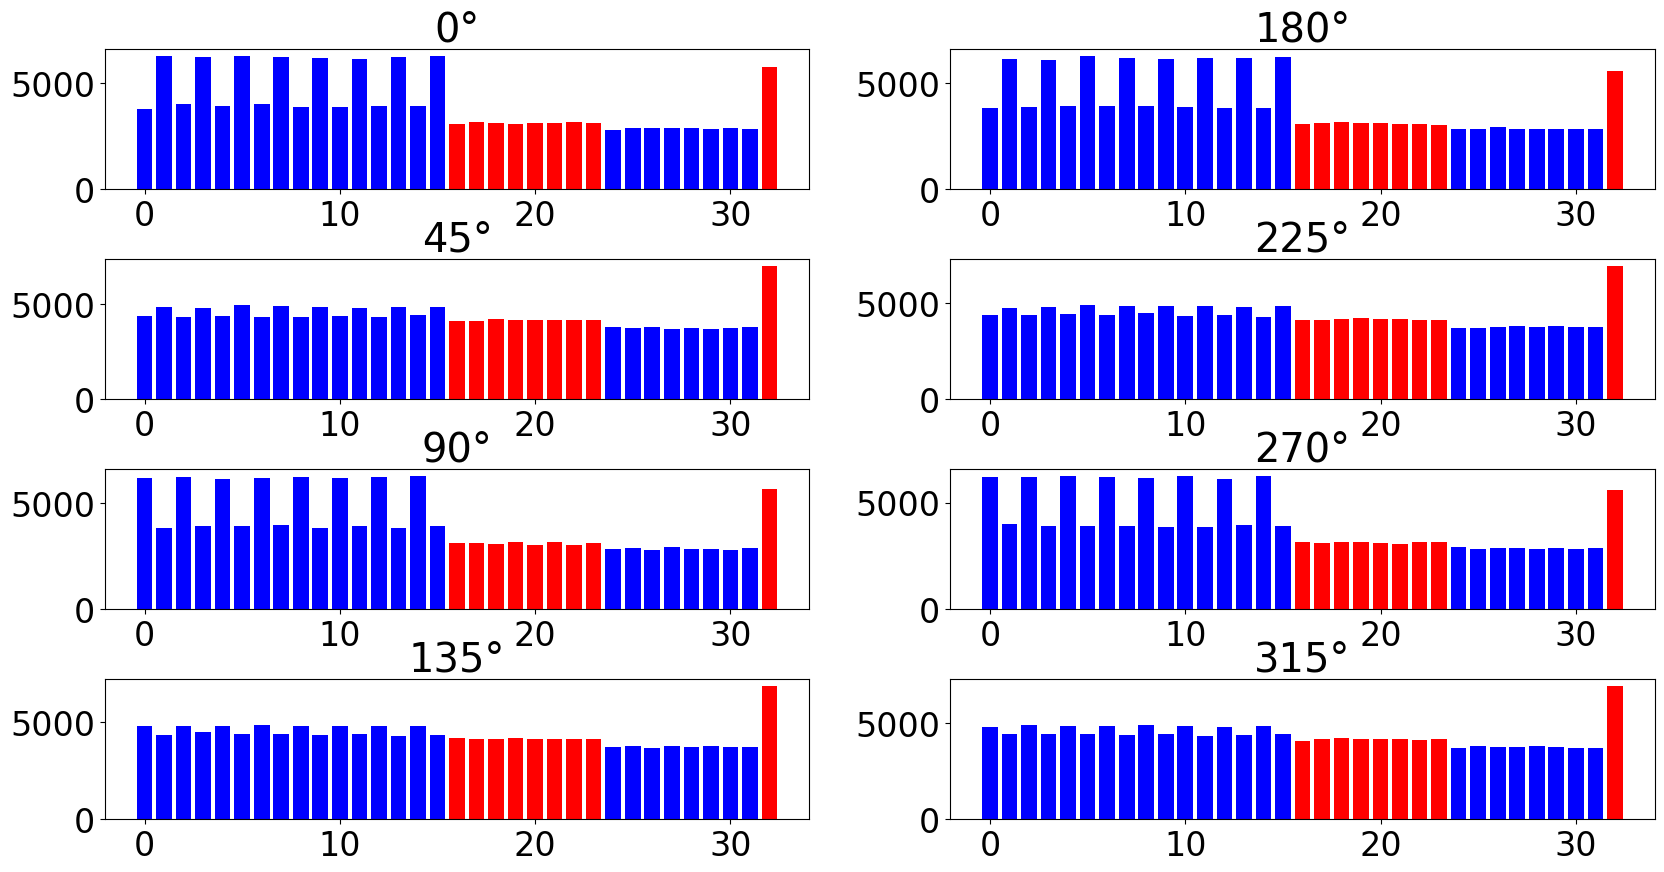

In [13]:
# Per angle pruning
plt.rcParams.update({'font.size': 24})

angles = list(range(0,360,45))
dataset = pd.read_csv('../data/zoo_small.csv')
model = DBModelSmall(batch_first=False)
X, y = get_moons_dataset(n_samples=1000, noise=0.1)

handles = [
    Patch(facecolor="blue", label="Weight"),
    Patch(facecolor="red", label="Bias")
]
color = ["blue"]*16 + ["red"]*8 + ["blue"]*8 + ["red"]*1

fig, ax = plt.subplots(4, 2, figsize=(20,10))
plt.subplots_adjust(hspace = 0.5)
for angle in tqdm(angles):
    data = dataset[dataset["angle"] == angle]
    angles = data["angle"].to_numpy()
    data = data.drop(columns=["model_name", "angle"]).to_numpy()
    discard_rate = get_discard_map(data, model, angles, X, y)

    ax[(angle%180)//45][angle//180].bar(range(len(discard_rate)), discard_rate, color=color)
    ax[(angle%180)//45][angle//180].set_title(f"{angle}°")

plt.savefig("../reports/pruning-graphs-per-angle-small.pdf")
plt.show()

100%|██████████| 80000/80000 [03:37<00:00, 368.07it/s]


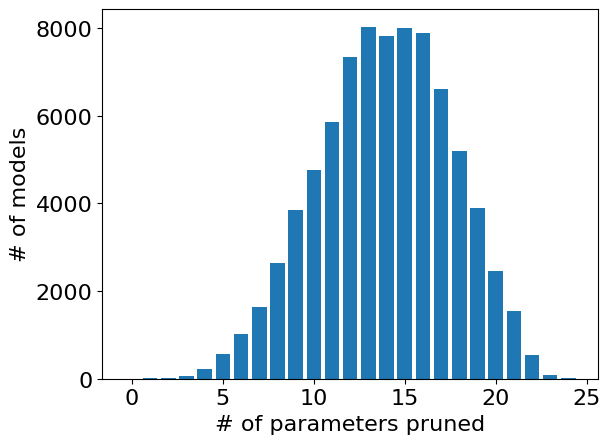

In [16]:
plt.rcParams.update({'font.size': 16})

data = np.genfromtxt('../data/zoo_small.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)
model = DBModelSmall(batch_first=False)

discard_rate = np.zeros((33))
discard_map = np.ones((33))
final_maps = []
discarded_counter = defaultdict(int)
X,y = get_moons_dataset()
for i in tqdm(range(80000)):
    weights = data[i]
    X_rotated = rotate(X, angles[i])
    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)
    for j in range(1, 33):
        mask = abs(weights).argsort().argsort() < j
        masked_weights = weights.copy()
        masked_weights[mask] = 0
        masked_weights = torch.tensor(masked_weights, dtype=torch.float32)
        model.set_weights(masked_weights)
        accuracy = get_accuracy(model, X_rotated, y)
        if(accuracy < 95):
            break
    mask = abs(weights).argsort().argsort() < j-1
    discarded_counter[j-1] += 1
    final_maps.append(mask)
    discard_rate += (discard_map * mask)

x = list(discarded_counter.keys())
y = list(discarded_counter.values())
plt.bar(x, y)
# plt.title("Parameters discarded (acc > 95%)")
plt.xlabel("# of parameters pruned")
plt.ylabel("# of models")
plt.savefig("../reports/pruning-histogram-small.pdf", bbox_inches='tight')
plt.show()

## Zoo #2

In [ ]:
data = np.genfromtxt('../data/zoo_medium_medium.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)
model = DBModelMedium(batch_first=False)

discard_rate = get_discard_map(data, model, angles, X, y)

plt.rcParams.update({'font.size': 14})

handles = [
        Patch(facecolor="blue", label="Weight"),
        Patch(facecolor="red", label="Bias")
    ]

color = ["blue"]*20 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*10 + ["red"]*1
plt.bar(range(33), discard_rate, color=color)
plt.xlabel("Parameter index")
plt.ylabel("# of models")

plt.legend(handles=handles)
plt.savefig("../reports/pruning-graph-medium.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# Per angle pruning
plt.rcParams.update({'font.size': 24})

angles = list(range(0,360,45))
dataset = pd.read_csv('../data/zoo_medium_medium.csv')
model = DBModelMedium(batch_first=False)
X, y = get_moons_dataset(n_samples=1000, noise=0.1)

handles = [
    Patch(facecolor="blue", label="Weight"),
    Patch(facecolor="red", label="Bias")
]
color = ["blue"]*20 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*10 + ["red"]*1

fig, ax = plt.subplots(4, 2, figsize=(20,10))
plt.subplots_adjust(hspace = 0.5)
for angle in tqdm(angles):
    data = dataset[dataset["angle"] == angle]
    angles = data["angle"].to_numpy()
    data = data.drop(columns=["model_name", "angle"]).to_numpy()
    discard_rate = get_discard_map(data, model, angles, X, y)

    ax[(angle%180)//45][angle//180].bar(range(len(discard_rate)), discard_rate, color=color)
    ax[(angle%180)//45][angle//180].set_title(f"{angle}°")

plt.savefig("../reports/pruning-graphs-per-angle-medium.pdf")
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 16})

data = np.genfromtxt('../data/zoo_medium_medium.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)
model = DBModelMedium(batch_first=False)

discard_rate = np.zeros((151))
discard_map = np.ones((151))
final_maps = []
discarded_counter = defaultdict(int)
X,y = get_moons_dataset()
for i in tqdm(range(80000)):
    weights = data[i]
    X_rotated = rotate(X, angles[i])
    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)
    for j in range(1, 151):
        mask = abs(weights).argsort().argsort() < j
        masked_weights = weights.copy()
        masked_weights[mask] = 0
        masked_weights = torch.tensor(masked_weights, dtype=torch.float32)
        model.set_weights(masked_weights)
        accuracy = get_accuracy(model, X_rotated, y)
        if(accuracy < 95):
            break
    mask = abs(weights).argsort().argsort() < j-1
    discarded_counter[j-1] += 1
    final_maps.append(mask)
    discard_rate += (discard_map * mask)

x = list(discarded_counter.keys())
y = list(discarded_counter.values())
plt.bar(x, y)
# plt.title("Parameters discarded (acc > 95%)")
plt.xlabel("# of parameters pruned")
plt.ylabel("# of models")
plt.savefig("../reports/pruning-histogram-medium.pdf", bbox_inches='tight')
plt.show()

## Zoo #3

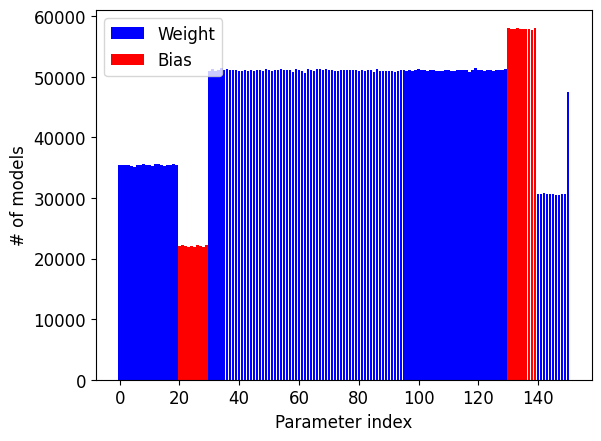

In [37]:
data = np.genfromtxt('../data/zoo_big.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)
model = DBModelBig(batch_first=False)

discard_rate = get_discard_map(data, model, angles, X, y)

plt.rcParams.update({'font.size': 14})

handles = [
        Patch(facecolor="blue", label="Weight"),
        Patch(facecolor="red", label="Bias")
    ]

color = ["blue"]*16 + ["red"]*8 + ["blue"]*8 + ["red"]*1
plt.bar(range(33), discard_rate, color=color)
plt.xlabel("Parameter index")
plt.ylabel("# of models")

plt.legend(handles=handles)
plt.savefig("../reports/pruning-graph-big.pdf", bbox_inches='tight')
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

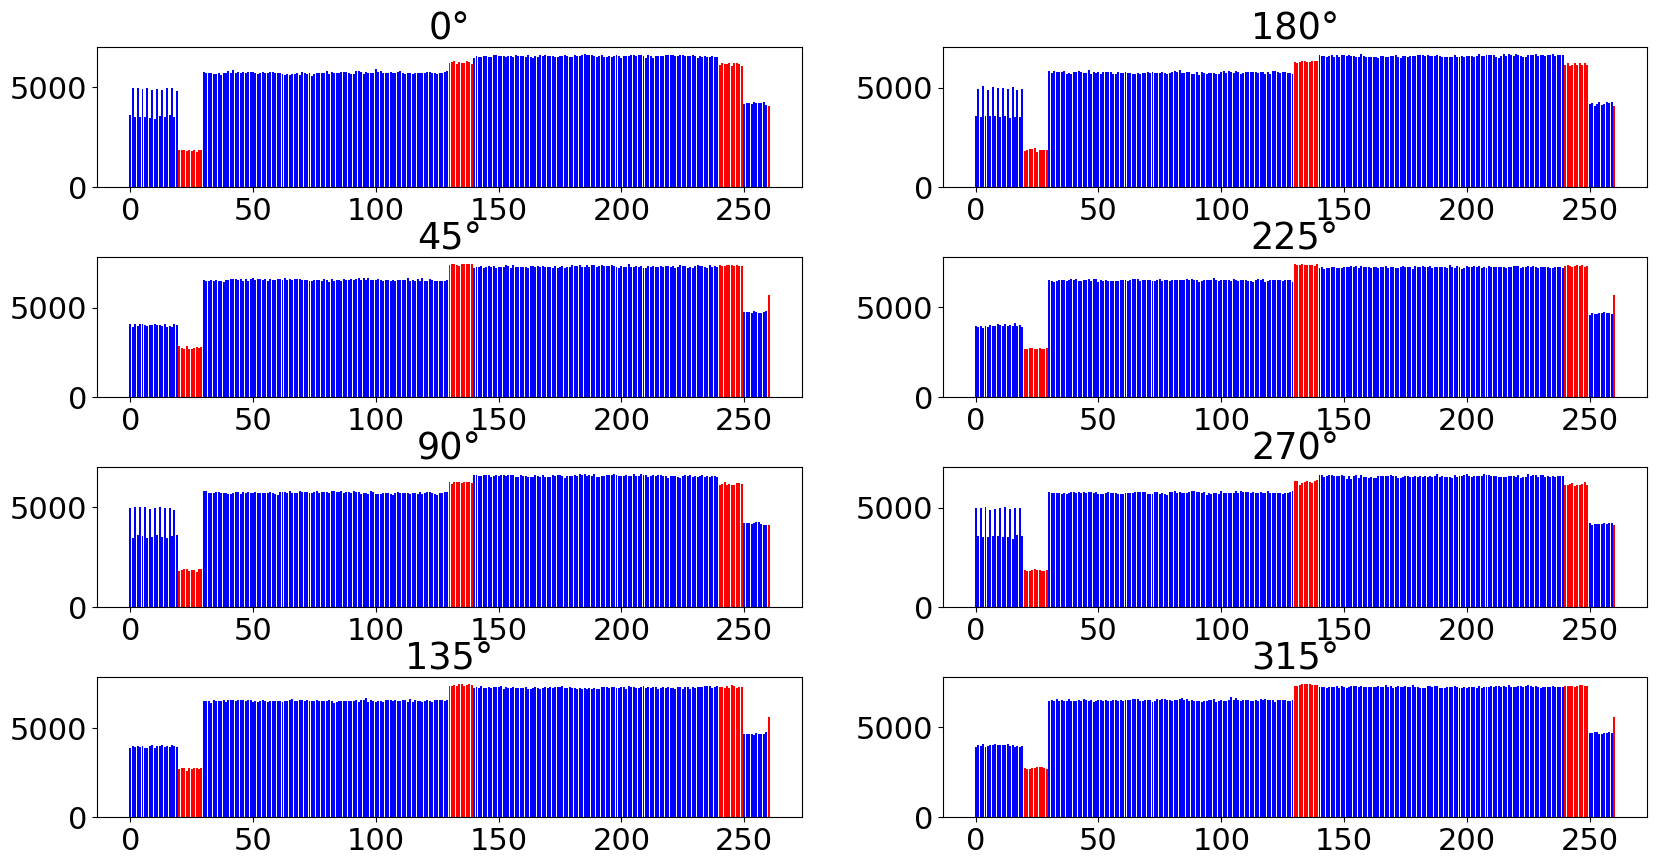

In [39]:
# Per angle pruning
plt.rcParams.update({'font.size': 24})

angles = list(range(0,360,45))
dataset = pd.read_csv('../data/zoo_big.csv')
model = DBModelBig(batch_first=False)
X, y = get_moons_dataset(n_samples=1000, noise=0.1)

handles = [
    Patch(facecolor="blue", label="Weight"),
    Patch(facecolor="red", label="Bias")
]
color = ["blue"]*20 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*10 + ["red"]*1

fig, ax = plt.subplots(4, 2, figsize=(20,10))
plt.subplots_adjust(hspace = 0.5)
for angle in tqdm(angles):
    data = dataset[dataset["angle"] == angle]
    angles = data["angle"].to_numpy()
    data = data.drop(columns=["model_name", "angle"]).to_numpy()
    discard_rate = get_discard_map(data, model, angles, X, y)

    ax[(angle%180)//45][angle//180].bar(range(len(discard_rate)), discard_rate, color=color)
    ax[(angle%180)//45][angle//180].set_title(f"{angle}°")

plt.savefig("../reports/pruning-graphs-per-angle-big.pdf")
plt.show()

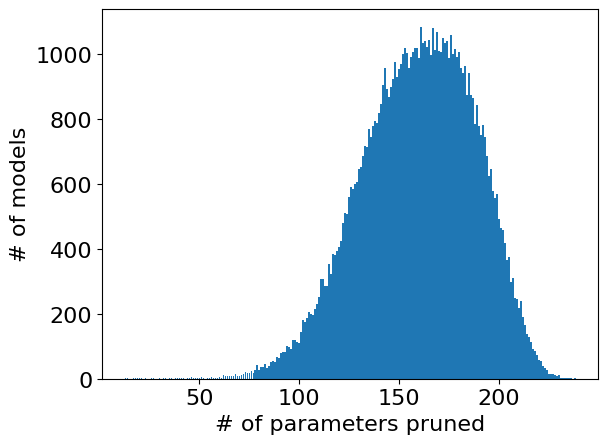

In [58]:
plt.rcParams.update({'font.size': 16})

data = np.genfromtxt('../data/zoo_big.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)
model = DBModelBig(batch_first=False)

discard_rate = np.zeros((261))
discard_map = np.ones((261))
final_maps = []
discarded_counter = defaultdict(int)
X,y = get_moons_dataset()
for i in tqdm(range(80000)):
    weights = data[i]
    X_rotated = rotate(X, angles[i])
    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)
    for j in range(1, 261):
        mask = abs(weights).argsort().argsort() < j
        masked_weights = weights.copy()
        masked_weights[mask] = 0
        masked_weights = torch.tensor(masked_weights, dtype=torch.float32)
        model.set_weights(masked_weights)
        accuracy = get_accuracy(model, X_rotated, y)
        if(accuracy < 95):
            break
    mask = abs(weights).argsort().argsort() < j-1
    discarded_counter[j-1] += 1
    final_maps.append(mask)
    discard_rate += (discard_map * mask)

x = list(discarded_counter.keys())
y = list(discarded_counter.values())
plt.bar(x, y)
# plt.title("Parameters discarded (acc > 95%)")
plt.xlabel("# of parameters pruned")
plt.ylabel("# of models")
plt.savefig("../reports/pruning-histogram-big.pdf", bbox_inches='tight')
plt.show()